# Modeling Notebook

In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from collections import defaultdict
import datetime, random
from collections import Counter
from scipy import sparse
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

import numpy as np
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white' # or EAEAF2
plt.rcParams['font.size'] = 16


First I'm going to make a quick way to get movie titles from movie ids

In [2]:
movies = pd.read_csv('../../../data/movies.csv')
decoder = dict(zip(movies.movieId, movies.title))

just a check

In [3]:
decoder[33312]

'Cocoanuts, The (1929)'

In [4]:
movies.sample(10)

,movieId,title,genres
5999,37475,"Unfinished Life, An (2005)",Drama
8724,126548,The DUFF (2015),Comedy
4785,7124,Grass (1999),Documentary
6485,53024,Jonestown: The Life and Death of Peoples Templ...,Documentary
496,574,Spanking the Monkey (1994),Comedy|Drama
2479,3302,Beautiful People (1999),Comedy
501,581,"Celluloid Closet, The (1995)",Documentary
3302,4467,"Adventures of Baron Munchausen, The (1988)",Adventure|Comedy|Fantasy
5099,8092,Frankenstein Unbound (1990),Drama|Horror|Sci-Fi
5865,32862,With Six You Get Eggroll (1968),Comedy|Romance


Let's make a reader object to read the ratings csv

In [14]:

reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1, rating_scale=(.5,5))
data = Dataset.load_from_file('../../../data/ratings.csv', reader)

Let's make a test split and fit an SVD model to our training setf

In [15]:
trainset, testset = train_test_split(data, test_size=.25)

algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8729


0.8728868131988667

In [16]:

[pred for pred in predictions if pred[0] == '561']

[Prediction(uid='561', iid='8798', r_ui=3.0, est=3.5178904356547918, details={'was_impossible': False}),
 Prediction(uid='561', iid='48304', r_ui=3.0, est=3.521632340323983, details={'was_impossible': False}),
 Prediction(uid='561', iid='4121', r_ui=3.0, est=3.3350491530142015, details={'was_impossible': False}),
 Prediction(uid='561', iid='5266', r_ui=1.5, est=2.857199352766968, details={'was_impossible': False}),
 Prediction(uid='561', iid='1196', r_ui=5.0, est=4.233009510159603, details={'was_impossible': False}),
 Prediction(uid='561', iid='4262', r_ui=4.0, est=3.7426496784659253, details={'was_impossible': False}),
 Prediction(uid='561', iid='4963', r_ui=3.5, est=3.7216645514902793, details={'was_impossible': False}),
 Prediction(uid='561', iid='6377', r_ui=3.5, est=3.7146335312483907, details={'was_impossible': False}),
 Prediction(uid='561', iid='1517', r_ui=3.5, est=3.549717212694168, details={'was_impossible': False}),
 Prediction(uid='561', iid='6502', r_ui=4.0, est=3.6097399

In [17]:
predictions

[Prediction(uid='134', iid='288', r_ui=4.0, est=3.816980593543996, details={'was_impossible': False}),
 Prediction(uid='448', iid='2139', r_ui=3.0, est=2.564278210412148, details={'was_impossible': False}),
 Prediction(uid='498', iid='300', r_ui=4.0, est=3.924208875523359, details={'was_impossible': False}),
 Prediction(uid='94', iid='410', r_ui=3.0, est=2.7441310655393742, details={'was_impossible': False}),
 Prediction(uid='427', iid='5449', r_ui=3.0, est=2.601600583959013, details={'was_impossible': False}),
 Prediction(uid='400', iid='76093', r_ui=4.5, est=4.089595092035021, details={'was_impossible': False}),
 Prediction(uid='232', iid='7294', r_ui=2.5, est=3.281979108901426, details={'was_impossible': False}),
 Prediction(uid='28', iid='49530', r_ui=4.5, est=2.8650085415411857, details={'was_impossible': False}),
 Prediction(uid='608', iid='608', r_ui=3.0, est=4.058126682118081, details={'was_impossible': False}),
 Prediction(uid='474', iid='22', r_ui=3.0, est=3.4391425619623646,

In [18]:
algo.predict()

TypeError: predict() missing 2 required positional arguments: 'uid' and 'iid'

In [5]:
ratings = pd.read_csv('../../../data/ratings.csv')
movies = pd.read_csv('../../../data/movies.csv')

In [6]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [7]:
movies['release_year'] = movies.title.apply(lambda x: x.strip()[-5:-1])
movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')

In [8]:
bigdf = ratings.join(movies.set_index('movieId'), on='movieId').dropna()

In [9]:
bigdf.head()

,userId,movieId,rating,timestamp,title,genres,release_year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,1995.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,1995.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995.0


In [10]:
groupedlil = bigdf.groupby('release_year')['rating'].mean()

In [11]:
# bigdf.set_index('timestamp').resample('Q')['rating'].mean().plot(figsize=(12,8))

Let's do the same thing with the big dataframe

In [12]:
# ratings = pd.read_csv('../../../data/ml-latest/ratings.csv')
# ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
# movies = pd.read_csv('../../../data/ml-latest/movies.csv')


In [13]:
# movies['release_year'] = movies.title.apply(lambda x: x.strip()[-5:-1])
# movies['release_year'] = pd.to_numeric(movies['release_year'], errors='coerce')
# bigdf = ratings.sample(1000000).join(movies.set_index('movieId'), on='movieId').dropna()
# grouped = bigdf.groupby('release_year')['rating'].mean()[1940:]

In [14]:
grouproll = groupedlil.rolling(10).mean()
grouproll

release_year
1902.0         NaN
1903.0         NaN
1908.0         NaN
1915.0         NaN
1916.0         NaN
            ...   
2014.0    3.499099
2015.0    3.504148
2016.0    3.493029
2017.0    3.498531
2018.0    3.494070
Name: rating, Length: 106, dtype: float64

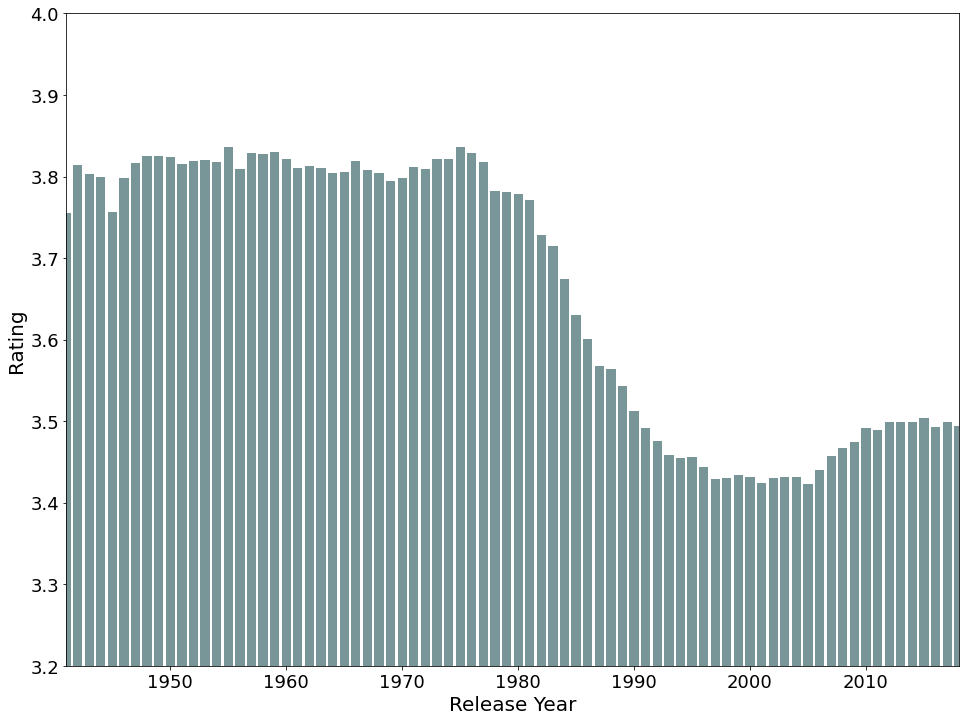

In [17]:
fig, ax = plt.subplots(figsize=(16,12))
ax.bar(grouproll[1940:].index, grouproll[1940:], linewidth=2, color='#789698')
ax.set_ylim([3.2,4])
ax.set_ylabel('Rating')
ax.set_xlabel('Release Year')
ax.set_xlim([1941, 2018])
plt.savefig('../../../src/figures/release_date.png')

In [194]:
int('10202020', base=3)

2733

[62193781,
 135382323952046197,
 294697851385443872747769973,
 641493077352987349716777460679790709,
 1396390799448264499694935779250702967590310005,
 3039638826391900708791813592927325535433367303710265461,
 6616632105109660076363899730488896757253096051716453117437890677,
 14402967890213203397193348041403391105316219366687717626610934002854875253,
 31352126089391288428985671993227098408551862011706930557762524681876266022276124789,
 68246754267431713644497201191946659452269404566993071646916091410272275214927650955289120885]

In [200]:
str()

[2, 8, 26, 80, 242, 728, 2186, 6560, 19682, 59048]